# <font color = 'indianred'>**Emotion Detection - MultiLabel** </font>

**Plan**

1. Set Environment
2. Load Dataset
3. Load Pre-trained Tokenizer
4. Train Model
     1. Compute Metric Function <br>
     2. Training Arguments <br>
     3. Specify Model
     4. Instantiate Trainer <br>
     5. Setup WandB <br>
     6. Training and Validation






















# <font color = 'indianred'> **1. Setting up the Environment** </font>



In [1]:
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  # Install the latest version of torchtext library quietly without showing output
  # !pip install torchtext -qq
  !pip install transformers evaluate wandb datasets accelerate peft bitsandbytes -U -qq ## NEW LINES ##
  basepath = '/content/drive/MyDrive/data/'

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.3/277.3 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 24.6 MB

<font color = 'indianred'> *Load Libraries* </font>

In [2]:
# standard data science librraies for data handling and v isualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

import torch
import torch.nn as nn
from datasets import load_dataset
from transformers import (
    TrainingArguments,
    Trainer,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    BitsAndBytesConfig,
)

import wandb
import evaluate
import peft
from peft import (
    prepare_model_for_kbit_training,
    get_peft_model,
)

# <font color = 'indianred'> **2. Load_Dataset** </font>

In [3]:
base_folder = Path(basepath)
data_folder = base_folder/'datasets'
model_folder = base_folder/'models'
custom_functions = base_folder/'custom-functions'
model_folder.mkdir(exist_ok=True, parents = True)

In [4]:

from sklearn.model_selection import train_test_split

train_df = pd.read_csv(data_folder/'train_twitter.csv')
train_df=train_df.drop(columns=['ID'])

train_set, valid_df = train_test_split(train_df, test_size=0.4, random_state=42)

train_text = train_set['Tweet'].tolist()
train_label = train_set.drop(columns=['Tweet']).to_numpy().astype(float)

valid_text = valid_df['Tweet'].tolist()
valid_label = valid_df.drop(columns=['Tweet']).to_numpy().astype(float)

from datasets import load_dataset, DatasetDict, Dataset, Value, ClassLabel, Features

trainset = Dataset.from_dict({
    'text': train_text,
    'label': train_label
})

validset = Dataset.from_dict({
    'text': valid_text,
    'label': valid_label
})

emotion_data = DatasetDict({
    'train': trainset,
    'valid': validset
})

In [5]:
emotion_data['train'][0:4]

{'text': ['@HebertofNH any time a man who got paid to throw temper tantrums speaks up, you gotta listen.',
  'I got a short fuse when im sober.',
  'You have a #problem? Yes! Can you do #something about it? No! Than why ',
  '“Optimism may sometimes be delusional, but pessimism is always delusional.” —Alan Cohen #believe'],
 'label': [[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
  [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]]}

In [6]:
labels = ['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'love',
 'optimism',
 'pessimism',
 'sadness',
 'surprise',
 'trust']

# <font color = 'indianred'>**3. Load pre-trained Tokenizer**</font>



In [7]:
!huggingface-cli login
!huggingface-cli repo create Emotion_Repo


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in 

In [8]:
checkpoint = "google/gemma-1.1-2b-it"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

In [9]:
def tokenize_fn(batch):
    return tokenizer(text = batch["text"])

<font color = 'indianred'> *Use map function to apply tokenization to all splits*

In [10]:
tokenized_dataset= emotion_data.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(
    ['text']
)
# tokenized_dataset.set_format(type='torch')

Map:   0%|          | 0/4634 [00:00<?, ? examples/s]

Map:   0%|          | 0/3090 [00:00<?, ? examples/s]

In [11]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 4634
    })
    valid: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 3090
    })
})

#  <font color = 'indianred'> **4. Model Training**

##  <font color = 'indianred'> **4.1. compute_metrics function** </font>



In [12]:
accuracy_metric = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    #logits= logits[0]
    # print(logits.shape)
    preds = (logits > 0).astype(int)
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy':accuracy['accuracy'],
            }

## <font color = 'indianred'> **4.2. Training Arguments**</font>







In [13]:
# Define the directory where model checkpoints will be saved
run_name = "emotions_gemma_ia3_im"
base_folder = Path(basepath)
model_folder = base_folder / "models"/run_name
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=10,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    # gradient_accumulation_steps=2,
    # gradient_checkpointing=True,

    weight_decay=0.001,  # Apply L2 regularization to prevent overfitting
    learning_rate=5e-4,  # Step size for the optimizer during training
    lr_scheduler_type='linear',
    warmup_steps=0,  # Number of warmup steps for the learning rate scheduler
    optim='adamw_torch',  # Optimizer,
    # max_grad_norm = 1.0,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=100,  # Perform evaluation every 10 training steps
    #save_strategy="steps",  # Save model checkpoint at specified step intervals
    #save_steps=100,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    #logging_strategy='steps',
   # logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name=run_name,  # Experiment name for Weights & Biases

    # fp16=False,
    #bf16=True,
    # tf32= False
)


## <font color = 'indianred'> **4.3. Specify Model**</font>

In [14]:
!pip install accelerate

In [15]:
!pip install bitsandbytes

In [16]:
bnb_config = BitsAndBytesConfig(
  load_in_4bit=True,
  llm_int8_skip_modules = ['score'],
  bnb_4bit_quant_type="fp4",
  bnb_4bit_use_double_quant=True,
  bnb_4bit_compute_dtype=torch.bfloat16
)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels=11,
                                                           problem_type="multi_label_classification" ,
                                                           quantization_config=bnb_config)
model = prepare_model_for_kbit_training(model)
config = AutoConfig.from_pretrained(checkpoint)
id2label= {id_: label_ for id_, label_ in enumerate(labels)}
label2id = {label_: id_ for id_, label_ in enumerate(labels)}
config.id2label = id2label
config.label2id = label2id
model.config = config



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/618 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of GemmaForSequenceClassification were not initialized from the model checkpoint at google/gemma-1.1-2b-it and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
model

GemmaForSequenceClassification(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear4bit(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): Gemma

## <font color = 'indianred'> **4.4. PEFT Setup**</font>

In [18]:
import re
model_modules = str(model.modules)
pattern = r'\((\w+)\): Linear'
linear_layer_names = re.findall(pattern, model_modules)

names = []
# Print the names of the Linear layers
for name in linear_layer_names:
    names.append(name)
target_modules = list(set(names))
target_modules

['score',
 'o_proj',
 'v_proj',
 'down_proj',
 'q_proj',
 'gate_proj',
 'k_proj',
 'up_proj']

In [19]:
flant5_peft_config = peft.IA3Config(task_type="SEQ_CLS",
                                    peft_type="IA3",
                                    target_modules=['v_proj','up_proj','gate_proj','k_proj','down_proj','o_proj','q_proj','score'],
                                    feedforward_modules=[ 'o_proj', 'v_proj', 'up_proj'],
                                    inference_mode=False)
flant5_peft_model = get_peft_model(model, flant5_peft_config )
flant5_peft_model.print_trainable_parameters()

trainable params: 506,379 || all params: 2,506,701,334 || trainable%: 0.020201010512567112


In [20]:
flant5_peft_config.target_modules

{'down_proj',
 'gate_proj',
 'k_proj',
 'o_proj',
 'q_proj',
 'score',
 'up_proj',
 'v_proj'}

In [21]:
flant5_peft_model

PeftModelForSequenceClassification(
  (base_model): IA3Model(
    (model): GemmaForSequenceClassification(
      (model): GemmaModel(
        (embed_tokens): Embedding(256000, 2048, padding_idx=0)
        (layers): ModuleList(
          (0-17): 18 x GemmaDecoderLayer(
            (self_attn): GemmaSdpaAttention(
              (q_proj): ia3.Linear4bit(
                (base_layer): Linear4bit(in_features=2048, out_features=2048, bias=False)
                (ia3_l): ParameterDict(  (default): Parameter containing: [torch.cuda.FloatTensor of size 2048x1 (cuda:0)])
              )
              (k_proj): ia3.Linear4bit(
                (base_layer): Linear4bit(in_features=2048, out_features=256, bias=False)
                (ia3_l): ParameterDict(  (default): Parameter containing: [torch.cuda.FloatTensor of size 256x1 (cuda:0)])
              )
              (v_proj): ia3.Linear4bit(
                (base_layer): Linear4bit(in_features=2048, out_features=256, bias=False)
                (ia

##  <font color = 'indianred'> **4.4 Custom Trainer**</font>



In [22]:
def calculate_pos_weights(dataset):
    # Initialize counters for all labels
    num_labels = len(dataset['train']['label'][0])
    total_positives = [0] * num_labels
    total_negatives = [0] * num_labels

    # Count positives and negatives for each label
    for label_array in dataset['train']['label']:
        for i, label in enumerate(label_array):
            if label == 1:
                total_positives[i] += 1
            else:
                total_negatives[i] += 1

    # Calculate pos_weight for each label
    pos_weight = [total_negatives[i] / max(total_positives[i], 1) for i in range(num_labels)]
    return torch.tensor(pos_weight)

# Calculate the pos_weight using the training set
pos_weights = calculate_pos_weights(emotion_data)


In [23]:
pos_weights

tensor([ 1.6556,  6.1292,  1.5990,  4.8143,  1.7005,  8.0685,  2.3628,  7.8604,
         2.3531, 18.8034, 17.9143])

In [24]:
pos_weights= torch.tensor([2., 3., 2., 2., 2., 3., 2., 3., 2., 4., 4.])

In [25]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels").float()  # Ensure labels are float for BCE loss
        outputs = model(**inputs)
        logits = outputs.get("logits")

        device = next(model.parameters()).device

        loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weights.to(device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [26]:
trainer = CustomTrainer(
    model=flant5_peft_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,

)

## <font color = 'indianred'> **4.5 Setup WandB**</font>

In [27]:
wandb.login()
%env WANDB_PROJECT = emotions_kaggle_S2024

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


env: WANDB_PROJECT=emotions_kaggle_S2024


## <font color = 'indianred'> **4.6. Start Training**</font>

In [28]:
trainer.train()  # start training

wandb: Currently logged in as: samanojvan (manojcompany). Use `wandb login --relogin` to force relogin


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
100,No log,0.610961,0.614197,0.489793,0.142395
200,No log,0.584511,0.621179,0.525595,0.138188
300,No log,0.570691,0.645965,0.530904,0.169256
400,No log,0.567885,0.648356,0.541692,0.178641
500,0.503000,0.581777,0.654013,0.542694,0.186731
600,0.503000,0.583896,0.645370,0.539506,0.171197
700,0.503000,0.596848,0.646003,0.539663,0.177023
800,0.503000,0.612871,0.644773,0.538647,0.181230
900,0.503000,0.624941,0.644764,0.538223,0.178641
1000,0.308100,0.639127,0.641935,0.536938,0.173786


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
100,No log,0.610961,0.614197,0.489793,0.142395
200,No log,0.584511,0.621179,0.525595,0.138188
300,No log,0.570691,0.645965,0.530904,0.169256
400,No log,0.567885,0.648356,0.541692,0.178641
500,0.503000,0.581777,0.654013,0.542694,0.186731
600,0.503000,0.583896,0.645370,0.539506,0.171197
700,0.503000,0.596848,0.646003,0.539663,0.177023
800,0.503000,0.612871,0.644773,0.538647,0.181230
900,0.503000,0.624941,0.644764,0.538223,0.178641
1000,0.308100,0.639127,0.641935,0.536938,0.173786


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


TrainOutput(global_step=1450, training_loss=0.34685115945750267, metrics={'train_runtime': 2145.9019, 'train_samples_per_second': 21.595, 'train_steps_per_second': 0.676, 'total_flos': 2.432421160818e+16, 'train_loss': 0.34685115945750267, 'epoch': 10.0})

## <font color = 'indianred'> **4.7. Validation**</font>


In [29]:
eval_results = trainer.evaluate(tokenized_dataset["valid"])

In [30]:
eval_results

{'eval_loss': 0.5817771553993225,
 'eval_f1_micro': 0.6540130854440629,
 'eval_f1_macro': 0.5426943364683126,
 'eval_accuracy': 0.18673139158576052,
 'eval_runtime': 37.0061,
 'eval_samples_per_second': 83.5,
 'eval_steps_per_second': 2.621,
 'epoch': 10.0}

In [31]:
wandb.log({"eval_accuracy": eval_results["eval_accuracy"], "eval_loss": eval_results["eval_loss"],
"eval_f1_micro": eval_results["eval_f1_micro"], "eval_f1_macro": eval_results["eval_f1_macro"]})

###  <font color = 'indianred'> **Check Confusion Matrix**</font>




In [32]:
# Use the trainer to generate predictions on the tokenized validation dataset.
# The resulting object, valid_output, will contain the model's logits (raw prediction scores) for each input in the validation set.
valid_output = trainer.predict(tokenized_dataset["valid"])

In [33]:
predictions_valid = (valid_output.predictions > 0).astype(int)
labels_valid = valid_output.label_ids.astype(int)

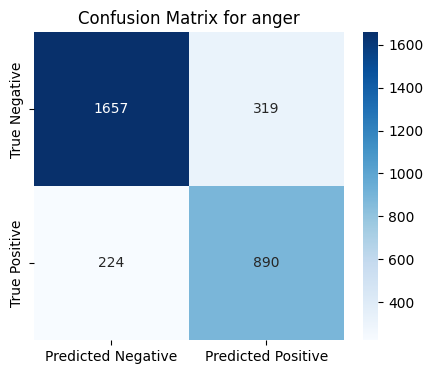

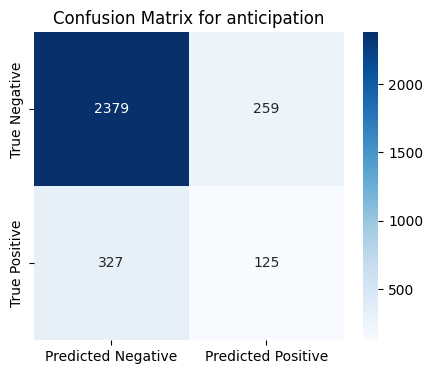

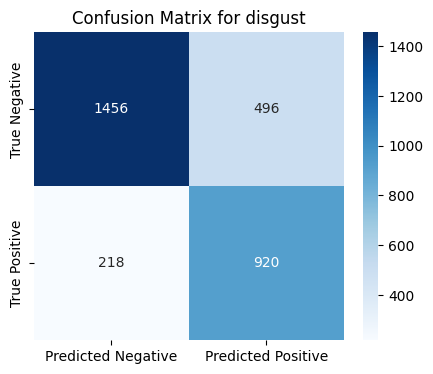

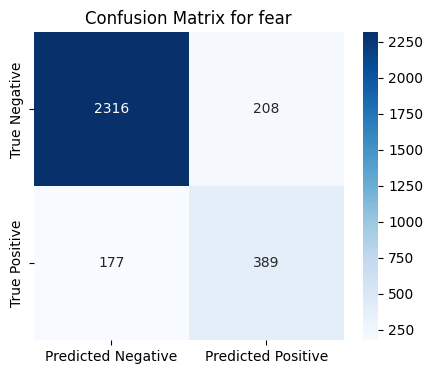

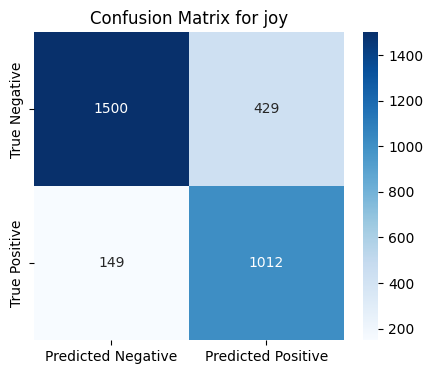

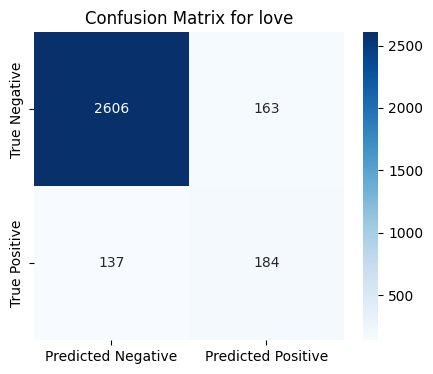

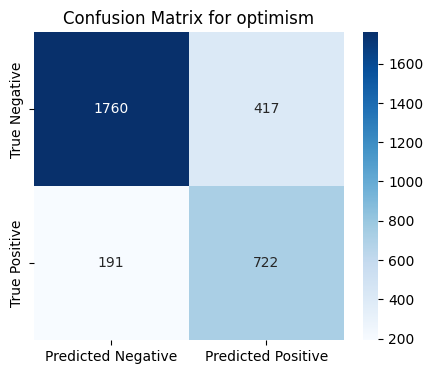

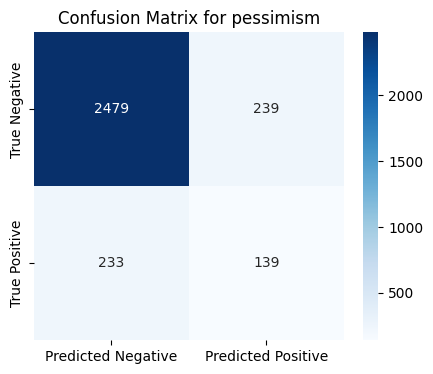

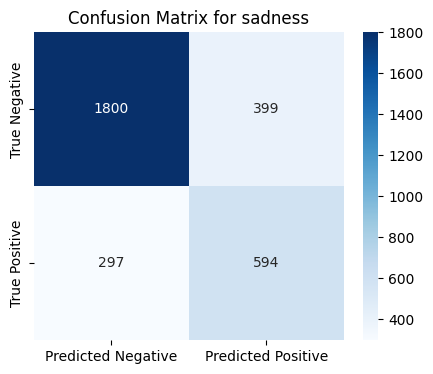

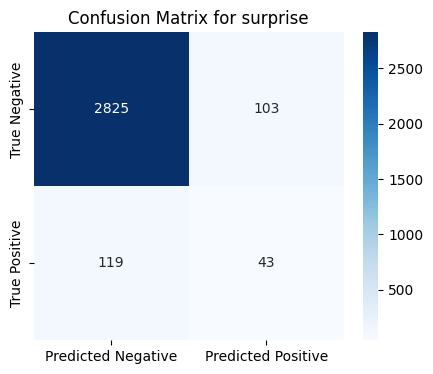

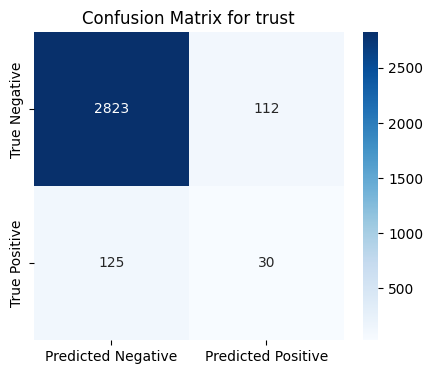

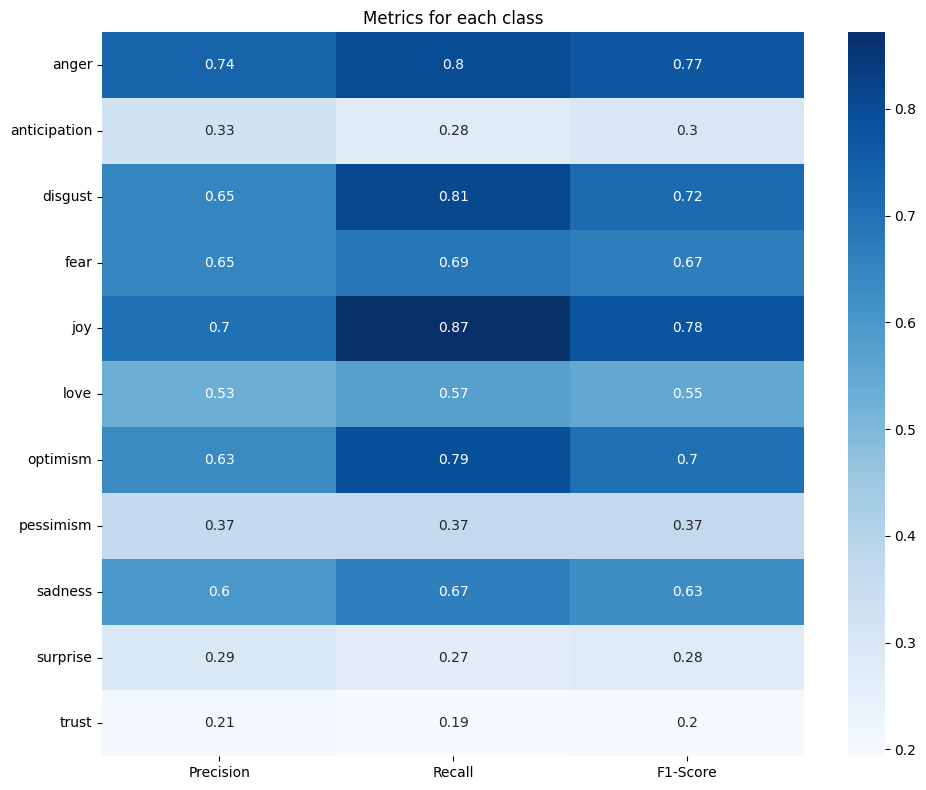

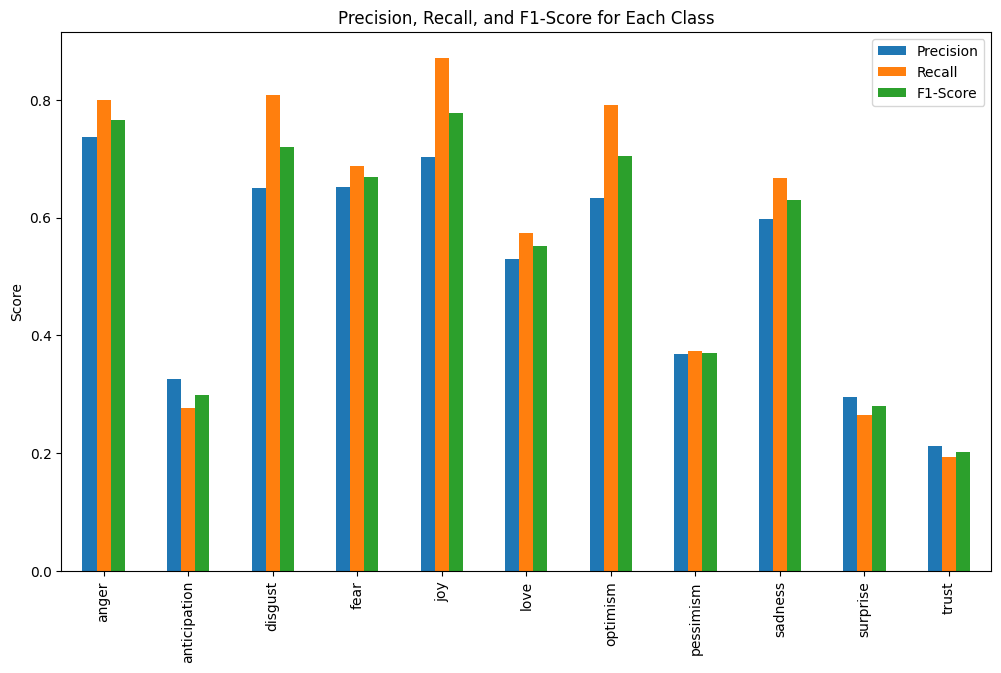

In [34]:
y_true = labels_valid
y_pred = predictions_valid
class_names = labels

mcm = multilabel_confusion_matrix(y_true, y_pred,)

# 1. Individual Heatmaps
for idx, matrix in enumerate(mcm):
    plt.figure(figsize=(5, 4))
    sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['True Negative', 'True Positive'])
    plt.title(f'Confusion Matrix for {class_names[idx]}')
    plt.show()

# 2. Aggregate Metrics Heatmap
precision_per_class = precision_score(y_true, y_pred, average=None)
recall_per_class = recall_score(y_true, y_pred, average=None)
f1_per_class = f1_score(y_true, y_pred, average=None)

metrics_df = pd.DataFrame({
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class
}, index=class_names)

plt.figure(figsize=(10, 8))
# sns.heatmap(metrics_df, annot=True, cmap='Blues')
# plt.title('Metrics for each class')
# plt.show()

ax = sns.heatmap(metrics_df, annot=True, cmap='Blues')
plt.title('Metrics for each class')
plt.tight_layout()  # Adjust layout to not cut off edges

# Log the heatmap to wandb
wandb.log({"Metrics Heatmap": wandb.Image(ax.get_figure())})
plt.show()

# 3. Histogram of Metrics
metrics_df.plot(kind='bar', figsize=(12, 7))
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score for Each Class')
plt.show()




In [35]:
wandb.finish()

eval/accuracy,▂▁▅▇█▆▇▇▇▆▆▇▇▇█
eval/f1_macro,▁▆▆████▇▇▇▇▇▇▆█
eval/f1_micro,▁▂▇▇█▆▇▆▆▆▅▆▅▅█
eval/loss,▄▂▁▁▂▂▃▄▅▆▆▇██▂
eval/runtime,▂▁▃▂▂▁▅▄▁▃█▄█▅█
eval/samples_per_second,▇█▆▇▇█▄▅█▆▁▅▁▄▁
eval/steps_per_second,▇▇▇▇▇▇▄▅█▅▁▅▁▄▁
eval_accuracy,▁
eval_f1_macro,▁
eval_f1_micro,▁
eval_loss,▁


In [ ]:
# from huggingface_hub import notebook_login
# notebook_login()

In [ ]:
# flant5_peft_model.push_to_hub("harpreetmann/flant5_ia3_model_emotion_detection")

# Test Set Predictions

In [ ]:
# import torch
# from peft import PeftModel, PeftConfig
# from transformers import AutoModelForSequenceClassification, AutoTokenizer

# peft_model_id = "harpreetmann/flant5_ia3_emotion_detection"
# config = PeftConfig.from_pretrained(peft_model_id)
# config.base_model_name_or_path
# base_model = AutoModelForSequenceClassification.from_pretrained(config.base_model_name_or_path,
#                                                                 num_labels=11,
#                                                                 problem_type="multi_label_classification")
# tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)


In [ ]:
# base_model

In [ ]:
# # Load the peft model
# inference_model = PeftModel.from_pretrained(base_model, peft_model_id)

In [ ]:
# inference_model